# EOF analysis of a monthly SST dataset.

In [5]:
!wget ftp://ftp.cdc.noaa.gov/Datasets/noaa.ersst/sst.mnmean.nc # get the Extended Range SST data using wget,
                                                               # google ERSST for more information.

--2016-04-12 17:57:57--  ftp://ftp.cdc.noaa.gov/Datasets/noaa.ersst/sst.mnmean.nc
           => ‘sst.mnmean.nc’
Resolving ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)... 140.172.38.117
Connecting to ftp.cdc.noaa.gov (ftp.cdc.noaa.gov)|140.172.38.117|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Datasets/noaa.ersst ... done.
==> SIZE sst.mnmean.nc ... 53297767
==> PASV ... done.    ==> RETR sst.mnmean.nc ... done.
Length: 53297767 (51M) (unauthoritative)

sst.mnmean.nc       100%[=====================>]  50.83M  7.14MB/s   in 6.8s   

2016-04-12 17:58:05 (7.49 MB/s) - ‘sst.mnmean.nc’ saved [53297767]



In [6]:
from netCDF4 import Dataset
import numpy as np

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
sstda=Dataset('sst.mnmean.nc') # read the dataset 

In [9]:
sstda.variables #list all the variables in the dataset

OrderedDict([(u'lat', <type 'netCDF4._netCDF4.Variable'>
              float32 lat(lat)
                  units: degrees_north
                  long_name: Latitude
                  actual_range: [ 88. -88.]
                  standard_name: latitude
                  axis: Y
                  coordinate_defines: center
              unlimited dimensions: 
              current shape = (89,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'lon', <type 'netCDF4._netCDF4.Variable'>
              float32 lon(lon)
                  units: degrees_east
                  long_name: Longitude
                  actual_range: [   0.  358.]
                  standard_name: longitude
                  axis: X
                  coordinate_defines: center
              unlimited dimensions: 
              current shape = (180,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'time_bnds', <type 'netCDF4._netCDF4.Variable

In [10]:
sst=sstda.variables['sst'][:] # get the SST
np.shape(sst) #should be months,lats,lons

(1947, 89, 180)

In [11]:
lons = sstda.variables['lon'][:]
lats = sstda.variables['lat'][:]

In [31]:
from eofs.standard import Eof # import standard eofs from python eofs package, 
                              # to install eofs package use `pip install eofs`
                              # for API see http://ajdawson.github.io/eofs/api/index.html for more information.

In [18]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
# It is elegent to use weights but not necessarily mandatory.
coslat = np.cos(np.deg2rad(lats))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

In [ ]:
# Retrieve the leading EOF
eof1 = solver.eofs(neofs=1)
# Retrieve the EOF expressed as the correlation between the leading  PC time series 
# and the input SST anomalies at each grid point.
eof1asCorr = solver.eofsAsCorrelation(neofs=1)
# Retrieve the EOF expressed as the covariance between the leading  PC time series 
# and the input SST anomalies at each grid point.
eof1asCov = solver.eofsAsCovariance(neofs=1)
# Get the leading PC timeseries
pcs = solver.pcs(npcs=1)
eigenvals=solver.eigenvalues()
variance=solver.varianceFraction() # this is same as eigenvals/sum(eigenvals)

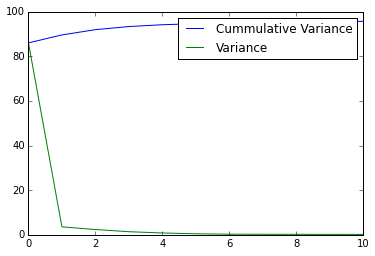

In [33]:
plt.plot(variance.cumsum()*100.0,label="Cummulative Variance")
plt.plot(variance*100.0,label="Variance")
plt.xlim(0,10,1)
plt.legend()

In [25]:
## Define a simple map plot function for convinience
def plotmapcolor(var,vlats,vlons):
    import matplotlib.pyplot as plt
    import mpl_toolkits
    import mpl_toolkits.basemap
    import numpy as np
    map = mpl_toolkits.basemap.Basemap(llcrnrlon=vlons.min(),llcrnrlat=vlats.min(),urcrnrlon=vlons.max(),urcrnrlat=vlats.max(),projection='cyl')
    map.drawcoastlines()
    longrid,latgrid = np.meshgrid(vlons,vlats)
    x,y=map(longrid,latgrid)
    map.contourf(x,y,var,15,cmap=plt.cm.hot_r)
    plt.colorbar(shrink=0.5)

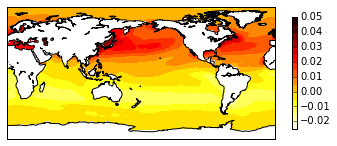

In [30]:
# Plot for leading EOF
plotmapcolor(eof1[0,:,:],lats,lons)

#### Question: What physical mode does the plot of EOF1 above represent? 

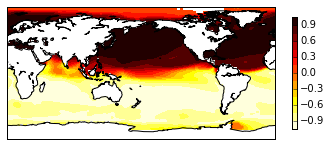

In [29]:
plotmapcolor(eof1asCorr[0,:,:],lats,lons) # Eof1 expressed as correlation between PC1 and SST anamolies

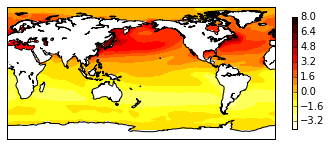

In [28]:
plotmapcolor(eof1asCov[0,:,:],lats,lons) # Eof1 expressed as covariance between PC1 and SSt anamolies

### Solve for second EOF and plot it

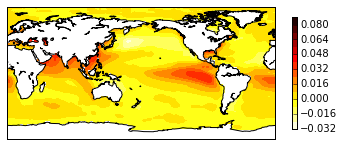

In [20]:
eof2 = solver.eofs(neofs=2)[1,:,:]
plotmapcolor(eof2,lats,lons)

#### Question: What physical mode does the plot of EOF2 above represent?

## Questions:
### 1. Subset the data to a region, say pacific (100E to 270E and 20S to 40N) and perform EOF analysis like above. Would the percent of variance exprressed by each EOF change? 
### 2. Above data is monthly data, subtract seasonal cycle (using longterm monthly means) and perform EOF analysis. How do you expect EOF1 to look like?
### 3. PC1 and PC2 of above question are a multi-year monthly time series. Express PCs as standard deviation along each calender month and explain what it means.   
### 4. Average the monthly data for each year to produce yearly SST. Perform EOF analysis on yearly SST dataset and describe the modes. 
### 5. Assume we add a random noise to the original SST dataset at each grid point. What do you expect it does to EOF analysis?
### 6. What are the units of EOFs when expressed in different forms as shown in the first example of this notebook. Is there a preferable way to express EOFs? 